<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/CIFAR10_cv_v003_4_ReduceLROnPlateau_LR_Scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10 CNN (v003-4) ###

*Given the significant demands on memory (and I am using a MacBook so no CUDA for me), have to run this in Google Colab for baller T4 CUDA...*

Inspired by this article - https://medium.com/@anderaquerretamontoro/the-best-cnn-for-cifar10-from-scratch-93-accuracy-bde35e17fca6;

I had originally built a CIFAR-10 model with params id'd and tuned from a RandomSearchCV 'grid search' using the sklearn PyTorch wrapper `skorch`. Which got me to some nice params that led to an ~89.33% accuracy on CIFAR-10. (That NB is in this same repo - https://github.com/data-alch3m1st/PyTorch_tinkering/blob/main/experimenting_code/skorch_CIFAR10_cv_v003_3.ipynb)

In that model, after finding some good hyperparams w/ Skorch (below), I used a learning rate annealing scheduler (CosineAnnealingLR), which seems to be a good way to go with this dataset. 
`torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)`

However, in the article above, the dev used a different lr_scheduler, `ReduceLROnPlateau` and was able to get >92% accuracy! Hence, I took the params gained from my original model, skipped the grid_search (as we already had good params) and rebuilt the model to use `lr_scheduler.ReduceLROnPlateau`, which is in the code below. While I did not get to 92%, I was able to improve slightly and after 200 Epochs, was hitting 89.82% accuracy. (Some minor tweeks on another run and I hope to hit >90%...)

Here were the original params tuned in the previous model which I brought over to this one:

`Best params: {'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 128}`

In [2]:
# !pip install skorch
# !pip install torchmetrics

In [3]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [4]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda"  # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps"  # Use Apple Silicon GPU (if available)
else:
    device = "cpu"  # Default to CPU if no GPU is available

device

'cuda'

In [5]:
# ---------------------------------------------------------
# 1. Prepare dataset (CIFAR-10) with Augmentations
# ---------------------------------------------------------

# Train transforms (with augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# Test transforms (only normalize)
test_transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# CIFAR-10 dataset download
dataset = datasets.CIFAR10(
    './data', train=True, download=True
)

# Extract raw data and labels
X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0  # Convert to [N, C, H, W]
y = torch.tensor(dataset.targets)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test .shape

100%|██████████| 170M/170M [01:12<00:00, 2.34MB/s]


(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [6]:
# ---------------------------------------------------------
# 2a. Apply Transforms for Augmentation/Normalization
# ---------------------------------------------------------

# Define functions to apply transforms to batches (used in DataLoader)
train_transform_batch = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

test_transform_batch = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])


In [7]:
# ---------------------------------------------------------
# 2b. Wrap in DataLoader for batching
# ---------------------------------------------------------

train_loader = DataLoader(
    list(zip(X_train, y_train))
    , batch_size=128
    , shuffle=True
)

test_loader = DataLoader(
    list(zip(X_test, y_test))
    , batch_size=128
    , shuffle=False
)

In [8]:
# ---------------------------------------------------------
# 3. Build the model class; (layers, blocks, forward, flatten, dropout, etc.)
# ---------------------------------------------------------

class Cifar10CNN_v3(nn.Module):
    def __init__(self, channels=64, dropout=0.3):
        super().__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels * 2)

        # Convolutional block 3
        self.conv3 = nn.Conv2d(channels * 2, channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels * 4)

        # Convolutional block 4
        self.conv4 = nn.Conv2d(channels * 4, channels * 8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels * 8)

        # Global average pooling to reduce overfitting
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(channels * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Global average pooling
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        return self.fc_out(x)

***Note: These hyperparams were tuned in another notebook using skorch, the sklearn PyTorch wrapper, to enable a RandomSearchCV 'grid search' to test a multitude of different hyper-params. The initial nb used a `CosineAnnealingLR` for LR Scheduling, but an article prompted me to take the same params and apply, but with a `ReduceLROnPlateau`.

Hence, rather than running through another grid search,  I am just taking the hyperparams I tuned from that, applying directly to the model, etc. and then just adjusting the `lr_scheduler` to `ReduceLROnPlateau`.

In [10]:
# Choose one of your param sets:
best_params = {
    'weight_decay': 0.0
    , 'momentum': 0.9
    , 'optimizer_cls': torch.optim.RMSprop
    , 'dropout': 0.3
    , 'channels': 64
    , 'lr': 3e-4
    , 'batch_size': 128
}

In [11]:
# Build model with module__* mapped to constructor args
model = Cifar10CNN_v3(
    channels=best_params['channels']
    , dropout=best_params['dropout'])

model

Cifar10CNN_v3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
"""
Best params: {'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 128}

"""

In [12]:
 # 8. Functionize the train & test loop(s):

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        # Apply train transforms to the batch
        X = train_transform_batch(X)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # Apply test transforms to the batch
            X = test_transform_batch(X)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [16]:
optimizer = best_params['optimizer_cls'](
    model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay'],
    momentum=best_params['momentum'],  # RMSprop supports momentum
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

In [19]:
%%time

# 10. Train the Best Model

epochs = 50  # For CIFAR-10, can start w/ 50 and do add'l 50 retrain if needed OR just go full 100;

# Move model to the device
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step(test_loss)  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  2%|▏         | 1/50 [00:05<04:43,  5.78s/it]

Epoch 1/50 - Train Loss: 1.3094, Train Acc: 0.52 - Test Loss: 1.2836, Test Acc: 0.54


  4%|▍         | 2/50 [00:11<04:29,  5.62s/it]

Epoch 2/50 - Train Loss: 1.1228, Train Acc: 0.60 - Test Loss: 1.3205, Test Acc: 0.56


  6%|▌         | 3/50 [00:16<04:19,  5.53s/it]

Epoch 3/50 - Train Loss: 0.9837, Train Acc: 0.65 - Test Loss: 0.8835, Test Acc: 0.69


  8%|▊         | 4/50 [00:22<04:13,  5.52s/it]

Epoch 4/50 - Train Loss: 0.8931, Train Acc: 0.69 - Test Loss: 0.9555, Test Acc: 0.67


 10%|█         | 5/50 [00:27<04:08,  5.52s/it]

Epoch 5/50 - Train Loss: 0.8215, Train Acc: 0.72 - Test Loss: 0.8798, Test Acc: 0.69


 12%|█▏        | 6/50 [00:33<04:02,  5.50s/it]

Epoch 6/50 - Train Loss: 0.7571, Train Acc: 0.74 - Test Loss: 0.7479, Test Acc: 0.75


 14%|█▍        | 7/50 [00:38<03:57,  5.53s/it]

Epoch 7/50 - Train Loss: 0.7005, Train Acc: 0.76 - Test Loss: 0.6492, Test Acc: 0.78


 16%|█▌        | 8/50 [00:44<03:52,  5.53s/it]

Epoch 8/50 - Train Loss: 0.6570, Train Acc: 0.78 - Test Loss: 0.6496, Test Acc: 0.78


 18%|█▊        | 9/50 [00:49<03:47,  5.55s/it]

Epoch 9/50 - Train Loss: 0.6221, Train Acc: 0.79 - Test Loss: 0.6375, Test Acc: 0.79


 20%|██        | 10/50 [00:55<03:41,  5.54s/it]

Epoch 10/50 - Train Loss: 0.5722, Train Acc: 0.81 - Test Loss: 0.6110, Test Acc: 0.80


 22%|██▏       | 11/50 [01:01<03:36,  5.56s/it]

Epoch 11/50 - Train Loss: 0.5599, Train Acc: 0.81 - Test Loss: 0.5903, Test Acc: 0.81


 24%|██▍       | 12/50 [01:06<03:30,  5.53s/it]

Epoch 12/50 - Train Loss: 0.5232, Train Acc: 0.82 - Test Loss: 0.5467, Test Acc: 0.82


 26%|██▌       | 13/50 [01:12<03:25,  5.55s/it]

Epoch 13/50 - Train Loss: 0.5007, Train Acc: 0.83 - Test Loss: 0.5151, Test Acc: 0.83


 28%|██▊       | 14/50 [01:17<03:18,  5.52s/it]

Epoch 14/50 - Train Loss: 0.4842, Train Acc: 0.84 - Test Loss: 0.5831, Test Acc: 0.81


 30%|███       | 15/50 [01:23<03:13,  5.53s/it]

Epoch 15/50 - Train Loss: 0.4652, Train Acc: 0.84 - Test Loss: 0.5224, Test Acc: 0.83


 32%|███▏      | 16/50 [01:28<03:07,  5.52s/it]

Epoch 16/50 - Train Loss: 0.4510, Train Acc: 0.85 - Test Loss: 0.5080, Test Acc: 0.83


 34%|███▍      | 17/50 [01:34<03:01,  5.50s/it]

Epoch 17/50 - Train Loss: 0.4242, Train Acc: 0.86 - Test Loss: 0.5484, Test Acc: 0.83


 36%|███▌      | 18/50 [01:39<02:56,  5.51s/it]

Epoch 18/50 - Train Loss: 0.4231, Train Acc: 0.86 - Test Loss: 0.4404, Test Acc: 0.86


 38%|███▊      | 19/50 [01:45<02:50,  5.50s/it]

Epoch 19/50 - Train Loss: 0.4094, Train Acc: 0.86 - Test Loss: 0.5399, Test Acc: 0.82


 40%|████      | 20/50 [01:50<02:45,  5.51s/it]

Epoch 20/50 - Train Loss: 0.3900, Train Acc: 0.87 - Test Loss: 0.4830, Test Acc: 0.84


 42%|████▏     | 21/50 [01:56<02:39,  5.51s/it]

Epoch 21/50 - Train Loss: 0.3764, Train Acc: 0.87 - Test Loss: 0.4519, Test Acc: 0.86


 44%|████▍     | 22/50 [02:01<02:34,  5.53s/it]

Epoch 22/50 - Train Loss: 0.3676, Train Acc: 0.88 - Test Loss: 0.4769, Test Acc: 0.85


 46%|████▌     | 23/50 [02:07<02:29,  5.53s/it]

Epoch 23/50 - Train Loss: 0.3562, Train Acc: 0.88 - Test Loss: 0.4325, Test Acc: 0.86


 48%|████▊     | 24/50 [02:12<02:24,  5.54s/it]

Epoch 24/50 - Train Loss: 0.3486, Train Acc: 0.88 - Test Loss: 0.4502, Test Acc: 0.86


 50%|█████     | 25/50 [02:18<02:18,  5.53s/it]

Epoch 25/50 - Train Loss: 0.3434, Train Acc: 0.88 - Test Loss: 0.4862, Test Acc: 0.85


 52%|█████▏    | 26/50 [02:23<02:13,  5.56s/it]

Epoch 26/50 - Train Loss: 0.3343, Train Acc: 0.89 - Test Loss: 0.4376, Test Acc: 0.86


 54%|█████▍    | 27/50 [02:29<02:07,  5.54s/it]

Epoch 27/50 - Train Loss: 0.3204, Train Acc: 0.89 - Test Loss: 0.4702, Test Acc: 0.85


 56%|█████▌    | 28/50 [02:34<02:01,  5.54s/it]

Epoch 28/50 - Train Loss: 0.3193, Train Acc: 0.89 - Test Loss: 0.4250, Test Acc: 0.86


 58%|█████▊    | 29/50 [02:40<01:56,  5.54s/it]

Epoch 29/50 - Train Loss: 0.3068, Train Acc: 0.90 - Test Loss: 0.4760, Test Acc: 0.85


 60%|██████    | 30/50 [02:45<01:50,  5.52s/it]

Epoch 30/50 - Train Loss: 0.3083, Train Acc: 0.90 - Test Loss: 0.4351, Test Acc: 0.86


 62%|██████▏   | 31/50 [02:51<01:44,  5.52s/it]

Epoch 31/50 - Train Loss: 0.3025, Train Acc: 0.90 - Test Loss: 0.4516, Test Acc: 0.86


 64%|██████▍   | 32/50 [02:56<01:39,  5.51s/it]

Epoch 32/50 - Train Loss: 0.2871, Train Acc: 0.90 - Test Loss: 0.4202, Test Acc: 0.87


 66%|██████▌   | 33/50 [03:02<01:33,  5.52s/it]

Epoch 33/50 - Train Loss: 0.2890, Train Acc: 0.90 - Test Loss: 0.4773, Test Acc: 0.86


 68%|██████▊   | 34/50 [03:07<01:28,  5.51s/it]

Epoch 34/50 - Train Loss: 0.2854, Train Acc: 0.90 - Test Loss: 0.4352, Test Acc: 0.86


 70%|███████   | 35/50 [03:13<01:22,  5.53s/it]

Epoch 35/50 - Train Loss: 0.2818, Train Acc: 0.91 - Test Loss: 0.4599, Test Acc: 0.86


 72%|███████▏  | 36/50 [03:19<01:17,  5.52s/it]

Epoch 36/50 - Train Loss: 0.2770, Train Acc: 0.91 - Test Loss: 0.4288, Test Acc: 0.87


 74%|███████▍  | 37/50 [03:24<01:11,  5.54s/it]

Epoch 37/50 - Train Loss: 0.2647, Train Acc: 0.91 - Test Loss: 0.4638, Test Acc: 0.87


 76%|███████▌  | 38/50 [03:30<01:06,  5.56s/it]

Epoch 38/50 - Train Loss: 0.2608, Train Acc: 0.91 - Test Loss: 0.4111, Test Acc: 0.88


 78%|███████▊  | 39/50 [03:35<01:01,  5.58s/it]

Epoch 39/50 - Train Loss: 0.2548, Train Acc: 0.91 - Test Loss: 0.4563, Test Acc: 0.86


 80%|████████  | 40/50 [03:41<00:55,  5.58s/it]

Epoch 40/50 - Train Loss: 0.2602, Train Acc: 0.91 - Test Loss: 0.4429, Test Acc: 0.87


 82%|████████▏ | 41/50 [03:47<00:52,  5.80s/it]

Epoch 41/50 - Train Loss: 0.2536, Train Acc: 0.91 - Test Loss: 0.4407, Test Acc: 0.87


 84%|████████▍ | 42/50 [03:53<00:46,  5.83s/it]

Epoch 42/50 - Train Loss: 0.2410, Train Acc: 0.92 - Test Loss: 0.4446, Test Acc: 0.87


 86%|████████▌ | 43/50 [03:59<00:40,  5.81s/it]

Epoch 43/50 - Train Loss: 0.2407, Train Acc: 0.92 - Test Loss: 0.4633, Test Acc: 0.86


 88%|████████▊ | 44/50 [04:04<00:34,  5.73s/it]

Epoch 44/50 - Train Loss: 0.2410, Train Acc: 0.92 - Test Loss: 0.4216, Test Acc: 0.88


 90%|█████████ | 45/50 [04:10<00:28,  5.67s/it]

Epoch 45/50 - Train Loss: 0.1836, Train Acc: 0.94 - Test Loss: 0.3851, Test Acc: 0.89


 92%|█████████▏| 46/50 [04:16<00:22,  5.63s/it]

Epoch 46/50 - Train Loss: 0.1661, Train Acc: 0.94 - Test Loss: 0.3985, Test Acc: 0.89


 94%|█████████▍| 47/50 [04:21<00:16,  5.58s/it]

Epoch 47/50 - Train Loss: 0.1524, Train Acc: 0.95 - Test Loss: 0.3990, Test Acc: 0.89


 96%|█████████▌| 48/50 [04:27<00:11,  5.57s/it]

Epoch 48/50 - Train Loss: 0.1479, Train Acc: 0.95 - Test Loss: 0.3916, Test Acc: 0.89


 98%|█████████▊| 49/50 [04:32<00:05,  5.55s/it]

Epoch 49/50 - Train Loss: 0.1412, Train Acc: 0.95 - Test Loss: 0.3985, Test Acc: 0.89


100%|██████████| 50/50 [04:38<00:00,  5.56s/it]

Epoch 50/50 - Train Loss: 0.1363, Train Acc: 0.95 - Test Loss: 0.4001, Test Acc: 0.89
CPU times: user 4min 32s, sys: 773 ms, total: 4min 33s
Wall time: 4min 38s


In [ ]:
# # print best train & test acc's;
# train_acc, test_acc

(0.9053264776357828, 0.8691653481012658)

In [20]:
# print best train & test acc's;
train_acc, test_acc

(0.9531499600638977, 0.8919106012658228)

In [21]:
# ---------------------------------------------------------
# 11: [UPDATED] Eval Mode for Final Predix, Metrics on Best & Fully Trained Model
# ---------------------------------------------------------

# 11a. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [22]:
# 11b. Compute metrics

print("\n Initial Evaluation after first 50 Epochs:")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


 Initial Evaluation after first 50 Epochs:
Accuracy: 0.8914

Confusion Matrix:
 [[914   3  29   8   3   6   4   3  17  13]
 [  9 942   2   2   0   1   4   0   9  31]
 [ 32   0 868  23  25  20  25   3   2   2]
 [ 20   1  41 772  30  77  46   7   2   4]
 [  8   0  25  24 893  15  16  17   1   1]
 [  2   0  22  89  30 833  16   6   1   1]
 [  5   2  14  18  11   8 935   2   4   1]
 [  5   0  19  29  24  21   5 896   0   1]
 [ 24   6   8   8   3   2   2   2 939   6]
 [ 13  28   3   5   2   3   2   4  18 922]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1000
           1       0.96      0.94      0.95      1000
           2       0.84      0.87      0.85      1000
           3       0.79      0.77      0.78      1000
           4       0.87      0.89      0.88      1000
           5       0.84      0.83      0.84      1000
           6       0.89      0.94      0.91      1000
           7       0.95      0

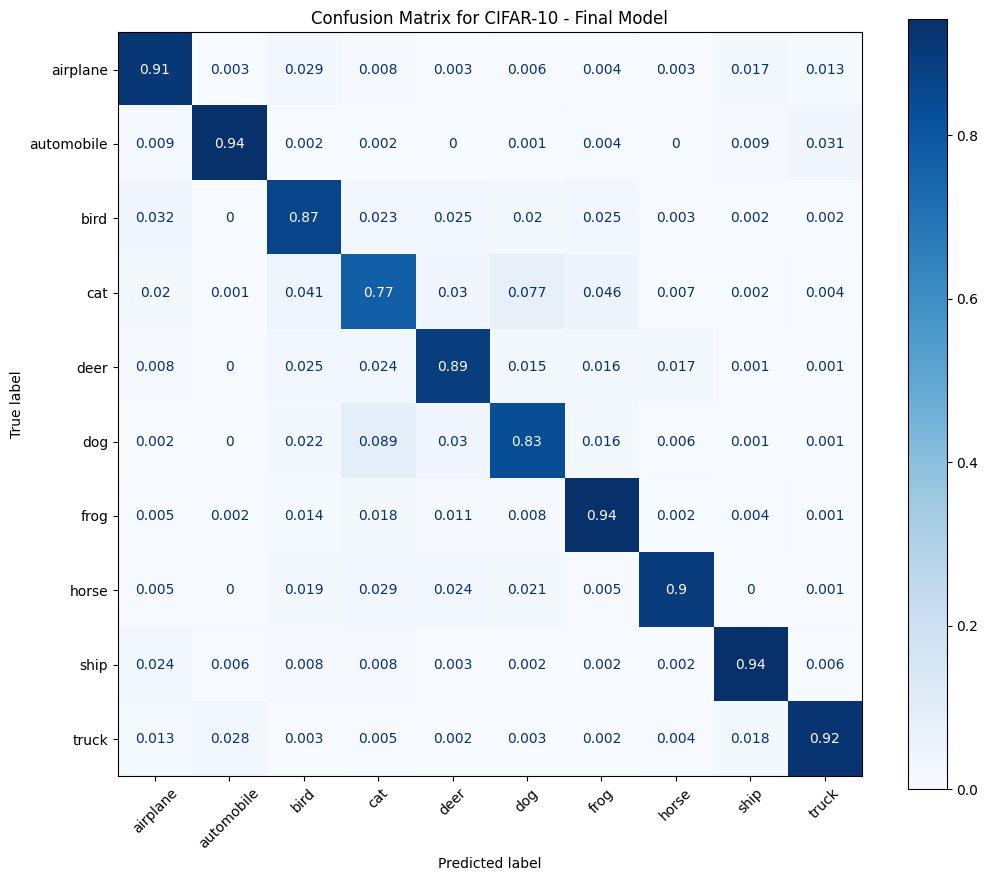

In [24]:
# ---------------------------------------------------------
# 12. Initial Confusion Matrix After First 50 Epochs
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [25]:
model

Cifar10CNN_v3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [26]:
# Save both model weights and optimizer state
torch.save({
    'epoch': epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn  # optional
}, "Cifar10CNN_v3-4_ReduceLRPlateau_best.pth")

print("Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best.pth")

Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best.pth


In [27]:
# 13. Retrain (If needed)

more_epochs = 100

# We already have the optimizer, lr_scheduler, loss_fn & accuracy_fn built, so don't need to re-create;

# Move model to the device
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step(test_loss)  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  2%|▏         | 1/50 [00:05<04:24,  5.40s/it]

Epoch 1/50 - Train Loss: 0.1353, Train Acc: 0.95 - Test Loss: 0.4049, Test Acc: 0.89


  4%|▍         | 2/50 [00:10<04:20,  5.42s/it]

Epoch 2/50 - Train Loss: 0.1329, Train Acc: 0.96 - Test Loss: 0.3989, Test Acc: 0.89


  6%|▌         | 3/50 [00:16<04:18,  5.50s/it]

Epoch 3/50 - Train Loss: 0.1279, Train Acc: 0.96 - Test Loss: 0.3963, Test Acc: 0.89


  8%|▊         | 4/50 [00:22<04:20,  5.66s/it]

Epoch 4/50 - Train Loss: 0.1257, Train Acc: 0.96 - Test Loss: 0.3966, Test Acc: 0.89


 10%|█         | 5/50 [00:27<04:11,  5.59s/it]

Epoch 5/50 - Train Loss: 0.1290, Train Acc: 0.96 - Test Loss: 0.3978, Test Acc: 0.89


 12%|█▏        | 6/50 [00:33<04:04,  5.56s/it]

Epoch 6/50 - Train Loss: 0.1236, Train Acc: 0.96 - Test Loss: 0.4034, Test Acc: 0.89


 14%|█▍        | 7/50 [00:38<03:59,  5.57s/it]

Epoch 7/50 - Train Loss: 0.1217, Train Acc: 0.96 - Test Loss: 0.4076, Test Acc: 0.89


 16%|█▌        | 8/50 [00:44<03:58,  5.68s/it]

Epoch 8/50 - Train Loss: 0.1209, Train Acc: 0.96 - Test Loss: 0.4044, Test Acc: 0.89


 18%|█▊        | 9/50 [00:50<03:53,  5.69s/it]

Epoch 9/50 - Train Loss: 0.1191, Train Acc: 0.96 - Test Loss: 0.4054, Test Acc: 0.89


 20%|██        | 10/50 [00:56<03:53,  5.83s/it]

Epoch 10/50 - Train Loss: 0.1165, Train Acc: 0.96 - Test Loss: 0.4129, Test Acc: 0.89


 22%|██▏       | 11/50 [01:02<03:46,  5.81s/it]

Epoch 11/50 - Train Loss: 0.1212, Train Acc: 0.96 - Test Loss: 0.4066, Test Acc: 0.89


 24%|██▍       | 12/50 [01:08<03:42,  5.86s/it]

Epoch 12/50 - Train Loss: 0.1188, Train Acc: 0.96 - Test Loss: 0.4046, Test Acc: 0.89


 26%|██▌       | 13/50 [01:14<03:34,  5.79s/it]

Epoch 13/50 - Train Loss: 0.1184, Train Acc: 0.96 - Test Loss: 0.4133, Test Acc: 0.89


 28%|██▊       | 14/50 [01:19<03:25,  5.70s/it]

Epoch 14/50 - Train Loss: 0.1120, Train Acc: 0.96 - Test Loss: 0.4126, Test Acc: 0.89


 30%|███       | 15/50 [01:25<03:19,  5.69s/it]

Epoch 15/50 - Train Loss: 0.1138, Train Acc: 0.96 - Test Loss: 0.4116, Test Acc: 0.89


 32%|███▏      | 16/50 [01:30<03:11,  5.62s/it]

Epoch 16/50 - Train Loss: 0.1183, Train Acc: 0.96 - Test Loss: 0.4253, Test Acc: 0.89


 34%|███▍      | 17/50 [01:36<03:04,  5.60s/it]

Epoch 17/50 - Train Loss: 0.1170, Train Acc: 0.96 - Test Loss: 0.4054, Test Acc: 0.89


 36%|███▌      | 18/50 [01:42<03:01,  5.68s/it]

Epoch 18/50 - Train Loss: 0.1106, Train Acc: 0.96 - Test Loss: 0.4163, Test Acc: 0.89


 38%|███▊      | 19/50 [01:47<02:54,  5.63s/it]

Epoch 19/50 - Train Loss: 0.1144, Train Acc: 0.96 - Test Loss: 0.4159, Test Acc: 0.89


 40%|████      | 20/50 [01:53<02:47,  5.57s/it]

Epoch 20/50 - Train Loss: 0.1120, Train Acc: 0.96 - Test Loss: 0.4106, Test Acc: 0.89


 42%|████▏     | 21/50 [01:58<02:41,  5.56s/it]

Epoch 21/50 - Train Loss: 0.1115, Train Acc: 0.96 - Test Loss: 0.4143, Test Acc: 0.89


 44%|████▍     | 22/50 [02:04<02:34,  5.53s/it]

Epoch 22/50 - Train Loss: 0.1102, Train Acc: 0.96 - Test Loss: 0.4091, Test Acc: 0.89


 46%|████▌     | 23/50 [02:09<02:29,  5.52s/it]

Epoch 23/50 - Train Loss: 0.1117, Train Acc: 0.96 - Test Loss: 0.4081, Test Acc: 0.90


 48%|████▊     | 24/50 [02:15<02:23,  5.52s/it]

Epoch 24/50 - Train Loss: 0.1089, Train Acc: 0.96 - Test Loss: 0.4141, Test Acc: 0.90


 50%|█████     | 25/50 [02:20<02:17,  5.51s/it]

Epoch 25/50 - Train Loss: 0.1102, Train Acc: 0.96 - Test Loss: 0.4182, Test Acc: 0.89


 52%|█████▏    | 26/50 [02:26<02:12,  5.52s/it]

Epoch 26/50 - Train Loss: 0.1055, Train Acc: 0.96 - Test Loss: 0.4251, Test Acc: 0.89


 54%|█████▍    | 27/50 [02:31<02:06,  5.51s/it]

Epoch 27/50 - Train Loss: 0.1067, Train Acc: 0.96 - Test Loss: 0.4181, Test Acc: 0.89


 56%|█████▌    | 28/50 [02:37<02:03,  5.62s/it]

Epoch 28/50 - Train Loss: 0.1058, Train Acc: 0.96 - Test Loss: 0.4281, Test Acc: 0.89


 58%|█████▊    | 29/50 [02:42<01:56,  5.57s/it]

Epoch 29/50 - Train Loss: 0.1072, Train Acc: 0.96 - Test Loss: 0.4198, Test Acc: 0.89


 60%|██████    | 30/50 [02:48<01:51,  5.56s/it]

Epoch 30/50 - Train Loss: 0.1092, Train Acc: 0.96 - Test Loss: 0.4262, Test Acc: 0.89


 62%|██████▏   | 31/50 [02:53<01:45,  5.53s/it]

Epoch 31/50 - Train Loss: 0.1022, Train Acc: 0.96 - Test Loss: 0.4323, Test Acc: 0.89


 64%|██████▍   | 32/50 [02:59<01:39,  5.53s/it]

Epoch 32/50 - Train Loss: 0.1070, Train Acc: 0.96 - Test Loss: 0.4177, Test Acc: 0.90


 66%|██████▌   | 33/50 [03:04<01:33,  5.51s/it]

Epoch 33/50 - Train Loss: 0.1073, Train Acc: 0.96 - Test Loss: 0.4225, Test Acc: 0.89


 68%|██████▊   | 34/50 [03:10<01:28,  5.52s/it]

Epoch 34/50 - Train Loss: 0.1082, Train Acc: 0.96 - Test Loss: 0.4156, Test Acc: 0.89


 70%|███████   | 35/50 [03:15<01:22,  5.51s/it]

Epoch 35/50 - Train Loss: 0.1054, Train Acc: 0.96 - Test Loss: 0.4188, Test Acc: 0.90


 72%|███████▏  | 36/50 [03:21<01:17,  5.50s/it]

Epoch 36/50 - Train Loss: 0.1030, Train Acc: 0.96 - Test Loss: 0.4195, Test Acc: 0.89


 74%|███████▍  | 37/50 [03:26<01:11,  5.50s/it]

Epoch 37/50 - Train Loss: 0.0989, Train Acc: 0.97 - Test Loss: 0.4219, Test Acc: 0.90


 76%|███████▌  | 38/50 [03:32<01:05,  5.49s/it]

Epoch 38/50 - Train Loss: 0.1019, Train Acc: 0.96 - Test Loss: 0.4381, Test Acc: 0.89


 78%|███████▊  | 39/50 [03:37<01:00,  5.50s/it]

Epoch 39/50 - Train Loss: 0.0997, Train Acc: 0.97 - Test Loss: 0.4290, Test Acc: 0.89


 80%|████████  | 40/50 [03:43<00:54,  5.48s/it]

Epoch 40/50 - Train Loss: 0.1012, Train Acc: 0.97 - Test Loss: 0.4265, Test Acc: 0.89


 82%|████████▏ | 41/50 [03:48<00:49,  5.50s/it]

Epoch 41/50 - Train Loss: 0.0959, Train Acc: 0.97 - Test Loss: 0.4187, Test Acc: 0.90


 84%|████████▍ | 42/50 [03:54<00:43,  5.48s/it]

Epoch 42/50 - Train Loss: 0.0968, Train Acc: 0.97 - Test Loss: 0.4396, Test Acc: 0.89


 86%|████████▌ | 43/50 [03:59<00:38,  5.50s/it]

Epoch 43/50 - Train Loss: 0.0987, Train Acc: 0.97 - Test Loss: 0.4430, Test Acc: 0.90


 88%|████████▊ | 44/50 [04:05<00:32,  5.49s/it]

Epoch 44/50 - Train Loss: 0.0967, Train Acc: 0.97 - Test Loss: 0.4305, Test Acc: 0.90


 90%|█████████ | 45/50 [04:10<00:27,  5.51s/it]

Epoch 45/50 - Train Loss: 0.0960, Train Acc: 0.97 - Test Loss: 0.4338, Test Acc: 0.90


 92%|█████████▏| 46/50 [04:16<00:22,  5.62s/it]

Epoch 46/50 - Train Loss: 0.0971, Train Acc: 0.97 - Test Loss: 0.4410, Test Acc: 0.89


 94%|█████████▍| 47/50 [04:22<00:16,  5.59s/it]

Epoch 47/50 - Train Loss: 0.0975, Train Acc: 0.97 - Test Loss: 0.4340, Test Acc: 0.90


 96%|█████████▌| 48/50 [04:27<00:11,  5.57s/it]

Epoch 48/50 - Train Loss: 0.1031, Train Acc: 0.96 - Test Loss: 0.4296, Test Acc: 0.90


 98%|█████████▊| 49/50 [04:33<00:05,  5.53s/it]

Epoch 49/50 - Train Loss: 0.0942, Train Acc: 0.97 - Test Loss: 0.4278, Test Acc: 0.90


100%|██████████| 50/50 [04:38<00:00,  5.58s/it]

Epoch 50/50 - Train Loss: 0.0962, Train Acc: 0.97 - Test Loss: 0.4262, Test Acc: 0.90


In [ ]:
# train_acc, test_acc

(0.9711212060702875, 0.8944818037974683)

In [28]:
train_acc, test_acc

(0.9676267971246006, 0.8966574367088608)

In [29]:
# 14a. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [31]:
# 14b. Compute metrics

print("\nFinal Evaluation after 100 Epochs (50 x 2)")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Convert back to tensors for torchmetrics
all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)

# print("\nFinal Evaluation with torchmetrics Metrics\n", cm_tensor)
# cm = ConfusionMatrix(num_classes=10, task='multiclass')
# cm_tensor = cm(all_preds_tensor, all_labels_tensor)
# # cm_tensor
# print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Final Evaluation after 100 Epochs (50 x 2)
Accuracy: 0.8962

Confusion Matrix:
 [[913   4  25  10   5   4   6   2  18  13]
 [ 11 952   0   1   0   1   3   0   8  24]
 [ 30   1 865  29  25  20  22   3   3   2]
 [ 18   0  30 804  22  72  42   6   3   3]
 [  5   0  20  25 898  16  13  20   2   1]
 [  2   0  22  92  28 828  12  13   2   1]
 [  6   2  13  17  13   9 932   3   5   0]
 [  4   1  18  28  21  18   5 903   1   1]
 [ 16   6   8   9   4   2   3   2 944   6]
 [ 15  32   2   5   1   1   2   1  18 923]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       0.95      0.95      0.95      1000
           2       0.86      0.86      0.86      1000
           3       0.79      0.80      0.80      1000
           4       0.88      0.90      0.89      1000
           5       0.85      0.83      0.84      1000
           6       0.90      0.93      0.91      1000
           7       0.95      0

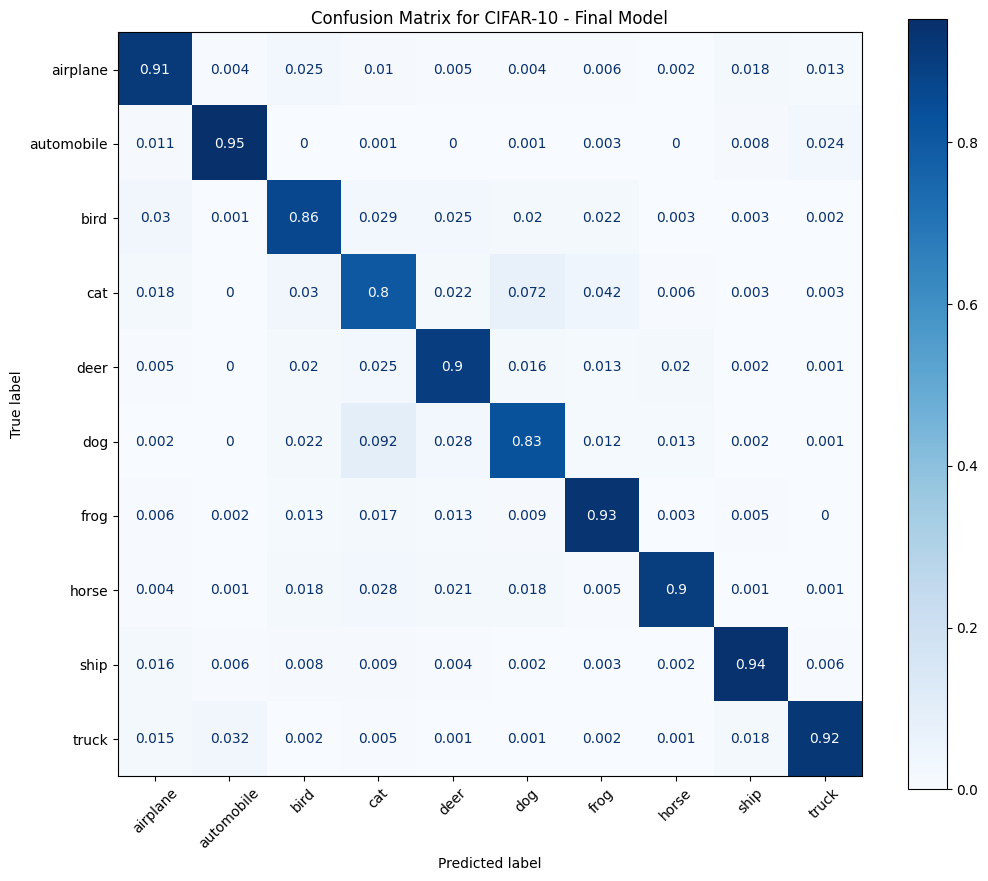

In [33]:
# 15. Final Confusion Matrix for Best & Fully Trained Model

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [34]:
# 16a. Save both model weights and optimizer state (in case you want to retrain, run add'l epochs, etc.)
torch.save({
    'epoch': epochs + more_epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn,  # optional
}, "Cifar10CNN_v3-4_ReduceLRPlateau_best_100_Epochs.pth")

print("Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best_100_Epochs.pth")

Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best_100_Epochs.pth


In [35]:
# 16b. Save best weights  (for eval mode only, so can only eval new data w/ weights; no add'l training;)
torch.save(model.state_dict(), "Cifar10CNN_v3-4_ReduceLRPlateau_100_Epochs_best_weights.pth")

In [ ]:
# Cifar10CNN_v3_best

# torch.save(model.state_dict(), "Cifar10CNN_v3_best_weights.pth")

In [36]:
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       0.95      0.95      0.95      1000
           2       0.86      0.86      0.86      1000
           3       0.79      0.80      0.80      1000
           4       0.88      0.90      0.89      1000
           5       0.85      0.83      0.84      1000
           6       0.90      0.93      0.91      1000
           7       0.95      0.90      0.92      1000
           8       0.94      0.94      0.94      1000
           9       0.95      0.92      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [39]:
# 17. Retrain (If needed)

more_epochs = 100

# We already have the optimizer, lr_scheduler, loss_fn & accuracy_fn built, so don't need to re-create;

# Move model to the device
model.to(device)

for epoch in tqdm(range(more_epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step(test_loss)  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  1%|          | 1/100 [00:05<09:03,  5.49s/it]

Epoch 1/50 - Train Loss: 0.0788, Train Acc: 0.97 - Test Loss: 0.4610, Test Acc: 0.90


  2%|▏         | 2/100 [00:11<08:59,  5.50s/it]

Epoch 2/50 - Train Loss: 0.0756, Train Acc: 0.97 - Test Loss: 0.4822, Test Acc: 0.89


  3%|▎         | 3/100 [00:16<08:55,  5.52s/it]

Epoch 3/50 - Train Loss: 0.0787, Train Acc: 0.97 - Test Loss: 0.5105, Test Acc: 0.89


  4%|▍         | 4/100 [00:22<08:49,  5.52s/it]

Epoch 4/50 - Train Loss: 0.0780, Train Acc: 0.97 - Test Loss: 0.4725, Test Acc: 0.90


  5%|▌         | 5/100 [00:27<08:47,  5.55s/it]

Epoch 5/50 - Train Loss: 0.0756, Train Acc: 0.97 - Test Loss: 0.4643, Test Acc: 0.90


  6%|▌         | 6/100 [00:33<08:41,  5.55s/it]

Epoch 6/50 - Train Loss: 0.0792, Train Acc: 0.97 - Test Loss: 0.4853, Test Acc: 0.90


  7%|▋         | 7/100 [00:38<08:37,  5.56s/it]

Epoch 7/50 - Train Loss: 0.0748, Train Acc: 0.97 - Test Loss: 0.4851, Test Acc: 0.90


  8%|▊         | 8/100 [00:44<08:29,  5.53s/it]

Epoch 8/50 - Train Loss: 0.0742, Train Acc: 0.97 - Test Loss: 0.4931, Test Acc: 0.90


  9%|▉         | 9/100 [00:49<08:23,  5.53s/it]

Epoch 9/50 - Train Loss: 0.0769, Train Acc: 0.97 - Test Loss: 0.4858, Test Acc: 0.90


 10%|█         | 10/100 [00:55<08:15,  5.51s/it]

Epoch 10/50 - Train Loss: 0.0750, Train Acc: 0.97 - Test Loss: 0.4837, Test Acc: 0.90


 11%|█         | 11/100 [01:00<08:10,  5.51s/it]

Epoch 11/50 - Train Loss: 0.0753, Train Acc: 0.97 - Test Loss: 0.5122, Test Acc: 0.90


 12%|█▏        | 12/100 [01:06<08:02,  5.49s/it]

Epoch 12/50 - Train Loss: 0.0763, Train Acc: 0.97 - Test Loss: 0.4802, Test Acc: 0.90


 13%|█▎        | 13/100 [01:11<07:57,  5.49s/it]

Epoch 13/50 - Train Loss: 0.0754, Train Acc: 0.97 - Test Loss: 0.5111, Test Acc: 0.90


 14%|█▍        | 14/100 [01:17<07:51,  5.48s/it]

Epoch 14/50 - Train Loss: 0.0741, Train Acc: 0.97 - Test Loss: 0.4793, Test Acc: 0.90


 15%|█▌        | 15/100 [01:22<07:44,  5.47s/it]

Epoch 15/50 - Train Loss: 0.0787, Train Acc: 0.97 - Test Loss: 0.5104, Test Acc: 0.90


 16%|█▌        | 16/100 [01:28<07:40,  5.48s/it]

Epoch 16/50 - Train Loss: 0.0744, Train Acc: 0.97 - Test Loss: 0.4865, Test Acc: 0.90


 17%|█▋        | 17/100 [01:33<07:36,  5.50s/it]

Epoch 17/50 - Train Loss: 0.0723, Train Acc: 0.98 - Test Loss: 0.5161, Test Acc: 0.90


 18%|█▊        | 18/100 [01:39<07:31,  5.51s/it]

Epoch 18/50 - Train Loss: 0.0761, Train Acc: 0.97 - Test Loss: 0.5022, Test Acc: 0.90


 19%|█▉        | 19/100 [01:44<07:24,  5.49s/it]

Epoch 19/50 - Train Loss: 0.0736, Train Acc: 0.97 - Test Loss: 0.4792, Test Acc: 0.90


 20%|██        | 20/100 [01:50<07:20,  5.51s/it]

Epoch 20/50 - Train Loss: 0.0732, Train Acc: 0.98 - Test Loss: 0.5113, Test Acc: 0.90


 21%|██        | 21/100 [01:55<07:14,  5.50s/it]

Epoch 21/50 - Train Loss: 0.0740, Train Acc: 0.98 - Test Loss: 0.4959, Test Acc: 0.90


 22%|██▏       | 22/100 [02:01<07:10,  5.52s/it]

Epoch 22/50 - Train Loss: 0.0732, Train Acc: 0.97 - Test Loss: 0.5037, Test Acc: 0.90


 23%|██▎       | 23/100 [02:06<07:03,  5.50s/it]

Epoch 23/50 - Train Loss: 0.0764, Train Acc: 0.97 - Test Loss: 0.4703, Test Acc: 0.90


 24%|██▍       | 24/100 [02:12<06:58,  5.51s/it]

Epoch 24/50 - Train Loss: 0.0731, Train Acc: 0.98 - Test Loss: 0.4947, Test Acc: 0.90


 25%|██▌       | 25/100 [02:17<06:53,  5.51s/it]

Epoch 25/50 - Train Loss: 0.0709, Train Acc: 0.98 - Test Loss: 0.5107, Test Acc: 0.90


 26%|██▌       | 26/100 [02:23<06:46,  5.50s/it]

Epoch 26/50 - Train Loss: 0.0745, Train Acc: 0.98 - Test Loss: 0.5063, Test Acc: 0.90


 27%|██▋       | 27/100 [02:28<06:41,  5.50s/it]

Epoch 27/50 - Train Loss: 0.0730, Train Acc: 0.98 - Test Loss: 0.4725, Test Acc: 0.90


 28%|██▊       | 28/100 [02:34<06:35,  5.49s/it]

Epoch 28/50 - Train Loss: 0.0705, Train Acc: 0.98 - Test Loss: 0.4916, Test Acc: 0.90


 29%|██▉       | 29/100 [02:39<06:30,  5.50s/it]

Epoch 29/50 - Train Loss: 0.0705, Train Acc: 0.97 - Test Loss: 0.4735, Test Acc: 0.90


 30%|███       | 30/100 [02:45<06:24,  5.49s/it]

Epoch 30/50 - Train Loss: 0.0727, Train Acc: 0.98 - Test Loss: 0.4870, Test Acc: 0.90


 31%|███       | 31/100 [02:50<06:19,  5.50s/it]

Epoch 31/50 - Train Loss: 0.0716, Train Acc: 0.98 - Test Loss: 0.4862, Test Acc: 0.90


 32%|███▏      | 32/100 [02:56<06:12,  5.48s/it]

Epoch 32/50 - Train Loss: 0.0717, Train Acc: 0.98 - Test Loss: 0.5022, Test Acc: 0.90


 33%|███▎      | 33/100 [03:01<06:08,  5.50s/it]

Epoch 33/50 - Train Loss: 0.0713, Train Acc: 0.98 - Test Loss: 0.4821, Test Acc: 0.90


 34%|███▍      | 34/100 [03:07<06:02,  5.49s/it]

Epoch 34/50 - Train Loss: 0.0689, Train Acc: 0.98 - Test Loss: 0.4916, Test Acc: 0.90


 35%|███▌      | 35/100 [03:12<05:57,  5.50s/it]

Epoch 35/50 - Train Loss: 0.0728, Train Acc: 0.97 - Test Loss: 0.4881, Test Acc: 0.90


 36%|███▌      | 36/100 [03:18<05:51,  5.50s/it]

Epoch 36/50 - Train Loss: 0.0712, Train Acc: 0.98 - Test Loss: 0.5239, Test Acc: 0.89


 37%|███▋      | 37/100 [03:23<05:45,  5.49s/it]

Epoch 37/50 - Train Loss: 0.0707, Train Acc: 0.98 - Test Loss: 0.5006, Test Acc: 0.90


 38%|███▊      | 38/100 [03:29<05:40,  5.50s/it]

Epoch 38/50 - Train Loss: 0.0713, Train Acc: 0.98 - Test Loss: 0.5047, Test Acc: 0.90


 39%|███▉      | 39/100 [03:34<05:34,  5.49s/it]

Epoch 39/50 - Train Loss: 0.0709, Train Acc: 0.98 - Test Loss: 0.4958, Test Acc: 0.90


 40%|████      | 40/100 [03:40<05:31,  5.52s/it]

Epoch 40/50 - Train Loss: 0.0644, Train Acc: 0.98 - Test Loss: 0.5073, Test Acc: 0.90


 41%|████      | 41/100 [03:45<05:24,  5.51s/it]

Epoch 41/50 - Train Loss: 0.0697, Train Acc: 0.98 - Test Loss: 0.4828, Test Acc: 0.90


 42%|████▏     | 42/100 [03:51<05:20,  5.53s/it]

Epoch 42/50 - Train Loss: 0.0687, Train Acc: 0.98 - Test Loss: 0.5169, Test Acc: 0.90


 43%|████▎     | 43/100 [03:56<05:14,  5.51s/it]

Epoch 43/50 - Train Loss: 0.0675, Train Acc: 0.98 - Test Loss: 0.5012, Test Acc: 0.90


 44%|████▍     | 44/100 [04:02<05:09,  5.53s/it]

Epoch 44/50 - Train Loss: 0.0699, Train Acc: 0.98 - Test Loss: 0.4987, Test Acc: 0.90


 45%|████▌     | 45/100 [04:07<05:03,  5.51s/it]

Epoch 45/50 - Train Loss: 0.0667, Train Acc: 0.98 - Test Loss: 0.5077, Test Acc: 0.90


 46%|████▌     | 46/100 [04:13<04:57,  5.51s/it]

Epoch 46/50 - Train Loss: 0.0651, Train Acc: 0.98 - Test Loss: 0.5185, Test Acc: 0.90


 47%|████▋     | 47/100 [04:18<04:51,  5.50s/it]

Epoch 47/50 - Train Loss: 0.0648, Train Acc: 0.98 - Test Loss: 0.5229, Test Acc: 0.90


 48%|████▊     | 48/100 [04:24<04:45,  5.50s/it]

Epoch 48/50 - Train Loss: 0.0657, Train Acc: 0.98 - Test Loss: 0.5175, Test Acc: 0.90


 49%|████▉     | 49/100 [04:29<04:40,  5.50s/it]

Epoch 49/50 - Train Loss: 0.0649, Train Acc: 0.98 - Test Loss: 0.5189, Test Acc: 0.90


 50%|█████     | 50/100 [04:35<04:34,  5.49s/it]

Epoch 50/50 - Train Loss: 0.0645, Train Acc: 0.98 - Test Loss: 0.5119, Test Acc: 0.90


 51%|█████     | 51/100 [04:40<04:29,  5.51s/it]

Epoch 51/50 - Train Loss: 0.0661, Train Acc: 0.98 - Test Loss: 0.5349, Test Acc: 0.90


 52%|█████▏    | 52/100 [04:46<04:24,  5.51s/it]

Epoch 52/50 - Train Loss: 0.0683, Train Acc: 0.98 - Test Loss: 0.5079, Test Acc: 0.90


 53%|█████▎    | 53/100 [04:51<04:19,  5.52s/it]

Epoch 53/50 - Train Loss: 0.0676, Train Acc: 0.98 - Test Loss: 0.5140, Test Acc: 0.90


 54%|█████▍    | 54/100 [04:57<04:12,  5.49s/it]

Epoch 54/50 - Train Loss: 0.0655, Train Acc: 0.98 - Test Loss: 0.4904, Test Acc: 0.90


 55%|█████▌    | 55/100 [05:02<04:07,  5.50s/it]

Epoch 55/50 - Train Loss: 0.0676, Train Acc: 0.98 - Test Loss: 0.5385, Test Acc: 0.89


 56%|█████▌    | 56/100 [05:08<04:01,  5.48s/it]

Epoch 56/50 - Train Loss: 0.0637, Train Acc: 0.98 - Test Loss: 0.5419, Test Acc: 0.90


 57%|█████▋    | 57/100 [05:13<03:56,  5.51s/it]

Epoch 57/50 - Train Loss: 0.0678, Train Acc: 0.98 - Test Loss: 0.5164, Test Acc: 0.90


 58%|█████▊    | 58/100 [05:19<03:50,  5.50s/it]

Epoch 58/50 - Train Loss: 0.0627, Train Acc: 0.98 - Test Loss: 0.5227, Test Acc: 0.90


 59%|█████▉    | 59/100 [05:24<03:45,  5.50s/it]

Epoch 59/50 - Train Loss: 0.0638, Train Acc: 0.98 - Test Loss: 0.5021, Test Acc: 0.90


 60%|██████    | 60/100 [05:30<03:40,  5.51s/it]

Epoch 60/50 - Train Loss: 0.0634, Train Acc: 0.98 - Test Loss: 0.5161, Test Acc: 0.90


 61%|██████    | 61/100 [05:35<03:34,  5.50s/it]

Epoch 61/50 - Train Loss: 0.0671, Train Acc: 0.98 - Test Loss: 0.5249, Test Acc: 0.90


 62%|██████▏   | 62/100 [05:41<03:29,  5.51s/it]

Epoch 62/50 - Train Loss: 0.0684, Train Acc: 0.98 - Test Loss: 0.5050, Test Acc: 0.90


 63%|██████▎   | 63/100 [05:46<03:23,  5.49s/it]

Epoch 63/50 - Train Loss: 0.0641, Train Acc: 0.98 - Test Loss: 0.5151, Test Acc: 0.90


 64%|██████▍   | 64/100 [05:52<03:18,  5.51s/it]

Epoch 64/50 - Train Loss: 0.0646, Train Acc: 0.98 - Test Loss: 0.5201, Test Acc: 0.90


 65%|██████▌   | 65/100 [05:57<03:12,  5.49s/it]

Epoch 65/50 - Train Loss: 0.0639, Train Acc: 0.98 - Test Loss: 0.5151, Test Acc: 0.90


 66%|██████▌   | 66/100 [06:03<03:07,  5.50s/it]

Epoch 66/50 - Train Loss: 0.0674, Train Acc: 0.98 - Test Loss: 0.5224, Test Acc: 0.90


 67%|██████▋   | 67/100 [06:08<03:01,  5.49s/it]

Epoch 67/50 - Train Loss: 0.0656, Train Acc: 0.98 - Test Loss: 0.5254, Test Acc: 0.90


 68%|██████▊   | 68/100 [06:14<02:56,  5.51s/it]

Epoch 68/50 - Train Loss: 0.0632, Train Acc: 0.98 - Test Loss: 0.5431, Test Acc: 0.90


 69%|██████▉   | 69/100 [06:19<02:50,  5.51s/it]

Epoch 69/50 - Train Loss: 0.0648, Train Acc: 0.98 - Test Loss: 0.5309, Test Acc: 0.90


 70%|███████   | 70/100 [06:25<02:45,  5.51s/it]

Epoch 70/50 - Train Loss: 0.0614, Train Acc: 0.98 - Test Loss: 0.5214, Test Acc: 0.90


 71%|███████   | 71/100 [06:30<02:39,  5.51s/it]

Epoch 71/50 - Train Loss: 0.0639, Train Acc: 0.98 - Test Loss: 0.5298, Test Acc: 0.90


 72%|███████▏  | 72/100 [06:36<02:33,  5.49s/it]

Epoch 72/50 - Train Loss: 0.0626, Train Acc: 0.98 - Test Loss: 0.5171, Test Acc: 0.90


 73%|███████▎  | 73/100 [06:41<02:28,  5.50s/it]

Epoch 73/50 - Train Loss: 0.0590, Train Acc: 0.98 - Test Loss: 0.5354, Test Acc: 0.90


 74%|███████▍  | 74/100 [06:47<02:22,  5.49s/it]

Epoch 74/50 - Train Loss: 0.0619, Train Acc: 0.98 - Test Loss: 0.5250, Test Acc: 0.90


 75%|███████▌  | 75/100 [06:52<02:17,  5.50s/it]

Epoch 75/50 - Train Loss: 0.0650, Train Acc: 0.98 - Test Loss: 0.5210, Test Acc: 0.90


 76%|███████▌  | 76/100 [06:58<02:11,  5.48s/it]

Epoch 76/50 - Train Loss: 0.0620, Train Acc: 0.98 - Test Loss: 0.5261, Test Acc: 0.90


 77%|███████▋  | 77/100 [07:03<02:06,  5.50s/it]

Epoch 77/50 - Train Loss: 0.0628, Train Acc: 0.98 - Test Loss: 0.5232, Test Acc: 0.90


 78%|███████▊  | 78/100 [07:09<02:04,  5.64s/it]

Epoch 78/50 - Train Loss: 0.0614, Train Acc: 0.98 - Test Loss: 0.5206, Test Acc: 0.90


 79%|███████▉  | 79/100 [07:15<01:57,  5.61s/it]

Epoch 79/50 - Train Loss: 0.0581, Train Acc: 0.98 - Test Loss: 0.5093, Test Acc: 0.90


 80%|████████  | 80/100 [07:20<01:51,  5.59s/it]

Epoch 80/50 - Train Loss: 0.0618, Train Acc: 0.98 - Test Loss: 0.5328, Test Acc: 0.90


 81%|████████  | 81/100 [07:26<01:45,  5.57s/it]

Epoch 81/50 - Train Loss: 0.0666, Train Acc: 0.98 - Test Loss: 0.5092, Test Acc: 0.90


 82%|████████▏ | 82/100 [07:31<01:39,  5.54s/it]

Epoch 82/50 - Train Loss: 0.0607, Train Acc: 0.98 - Test Loss: 0.5175, Test Acc: 0.90


 83%|████████▎ | 83/100 [07:37<01:33,  5.53s/it]

Epoch 83/50 - Train Loss: 0.0581, Train Acc: 0.98 - Test Loss: 0.5465, Test Acc: 0.90


 84%|████████▍ | 84/100 [07:42<01:28,  5.53s/it]

Epoch 84/50 - Train Loss: 0.0631, Train Acc: 0.98 - Test Loss: 0.5325, Test Acc: 0.90


 85%|████████▌ | 85/100 [07:48<01:22,  5.50s/it]

Epoch 85/50 - Train Loss: 0.0626, Train Acc: 0.98 - Test Loss: 0.5338, Test Acc: 0.90


 86%|████████▌ | 86/100 [07:53<01:17,  5.51s/it]

Epoch 86/50 - Train Loss: 0.0605, Train Acc: 0.98 - Test Loss: 0.5393, Test Acc: 0.90


 87%|████████▋ | 87/100 [07:59<01:11,  5.49s/it]

Epoch 87/50 - Train Loss: 0.0576, Train Acc: 0.98 - Test Loss: 0.5442, Test Acc: 0.90


 88%|████████▊ | 88/100 [08:04<01:06,  5.50s/it]

Epoch 88/50 - Train Loss: 0.0611, Train Acc: 0.98 - Test Loss: 0.5194, Test Acc: 0.90


 89%|████████▉ | 89/100 [08:10<01:00,  5.48s/it]

Epoch 89/50 - Train Loss: 0.0639, Train Acc: 0.98 - Test Loss: 0.5196, Test Acc: 0.90


 90%|█████████ | 90/100 [08:15<00:54,  5.50s/it]

Epoch 90/50 - Train Loss: 0.0609, Train Acc: 0.98 - Test Loss: 0.5227, Test Acc: 0.90


 91%|█████████ | 91/100 [08:21<00:49,  5.49s/it]

Epoch 91/50 - Train Loss: 0.0581, Train Acc: 0.98 - Test Loss: 0.5210, Test Acc: 0.90


 92%|█████████▏| 92/100 [08:26<00:44,  5.50s/it]

Epoch 92/50 - Train Loss: 0.0601, Train Acc: 0.98 - Test Loss: 0.5124, Test Acc: 0.90


 93%|█████████▎| 93/100 [08:32<00:38,  5.49s/it]

Epoch 93/50 - Train Loss: 0.0590, Train Acc: 0.98 - Test Loss: 0.5015, Test Acc: 0.90


 94%|█████████▍| 94/100 [08:37<00:32,  5.50s/it]

Epoch 94/50 - Train Loss: 0.0584, Train Acc: 0.98 - Test Loss: 0.5397, Test Acc: 0.90


 95%|█████████▌| 95/100 [08:43<00:27,  5.50s/it]

Epoch 95/50 - Train Loss: 0.0581, Train Acc: 0.98 - Test Loss: 0.5452, Test Acc: 0.90


 96%|█████████▌| 96/100 [08:48<00:21,  5.48s/it]

Epoch 96/50 - Train Loss: 0.0580, Train Acc: 0.98 - Test Loss: 0.5493, Test Acc: 0.90


 97%|█████████▋| 97/100 [08:54<00:16,  5.49s/it]

Epoch 97/50 - Train Loss: 0.0590, Train Acc: 0.98 - Test Loss: 0.5142, Test Acc: 0.90


 98%|█████████▊| 98/100 [08:59<00:10,  5.48s/it]

Epoch 98/50 - Train Loss: 0.0562, Train Acc: 0.98 - Test Loss: 0.5462, Test Acc: 0.90


 99%|█████████▉| 99/100 [09:05<00:05,  5.49s/it]

Epoch 99/50 - Train Loss: 0.0596, Train Acc: 0.98 - Test Loss: 0.5317, Test Acc: 0.90


100%|██████████| 100/100 [09:10<00:00,  5.51s/it]

Epoch 100/50 - Train Loss: 0.0598, Train Acc: 0.98 - Test Loss: 0.5342, Test Acc: 0.90


In [38]:
# train_acc, test_acc

(0.9721944888178914, 0.895371835443038)

In [40]:
train_acc, test_acc

(0.9790335463258786, 0.8986352848101266)

In [41]:
# 14a. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [43]:
# 14b. Compute metrics

print("\nFinal Evaluation after 200 Epochs (50 + 50 + 100)")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Convert back to tensors for torchmetrics
all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)

# print("\nFinal Evaluation with torchmetrics Metrics\n", cm_tensor)
# cm = ConfusionMatrix(num_classes=10, task='multiclass')
# cm_tensor = cm(all_preds_tensor, all_labels_tensor)
# # cm_tensor
# print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Final Evaluation after 200 Epochs (50 + 50 + 100)
Accuracy: 0.8982

Confusion Matrix:
 [[914   4  23  12   5   5   4   2  17  14]
 [ 13 950   0   1   0   1   4   0   7  24]
 [ 28   2 861  26  32  24  21   3   2   1]
 [ 14   0  23 817  26  73  36   6   3   2]
 [  4   0  19  30 902  10  18  15   1   1]
 [  2   0  18  92  29 837   9  11   1   1]
 [  6   1  13  19  11   8 935   3   3   1]
 [  6   1  19  28  26  20   5 894   0   1]
 [ 21   8   9  11   3   2   2   1 940   3]
 [ 15  25   2   5   2   2   2   1  14 932]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1000
           1       0.96      0.95      0.95      1000
           2       0.87      0.86      0.87      1000
           3       0.78      0.82      0.80      1000
           4       0.87      0.90      0.89      1000
           5       0.85      0.84      0.84      1000
           6       0.90      0.94      0.92      1000
           7       0.96

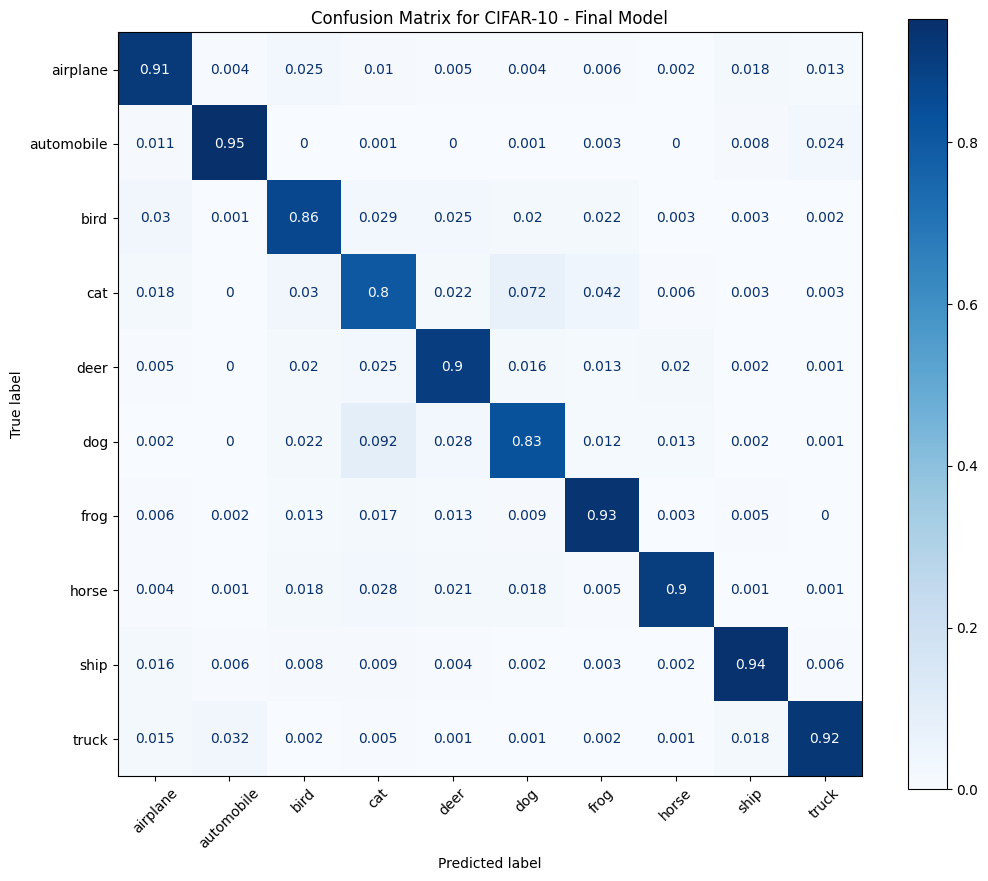

In [44]:
# 15. Final Confusion Matrix for Best & Fully Trained Model

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [45]:
# 16a. Save both model weights and optimizer state (in case you want to retrain, run add'l epochs, etc.)
torch.save({
    'epoch': epochs + more_epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn,  # optional
}, "Cifar10CNN_v3-4_ReduceLRPlateau_best_200_Epochs.pth")

print("Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best_200_Epochs.pth")

Model saved to Cifar10CNN_v3-4_ReduceLRPlateau_best_200_Epochs.pth


In [46]:
# 16b. Save best weights  (for eval mode only, so can only eval new data w/ weights; no add'l training;)
torch.save(model.state_dict(), "Cifar10CNN_v3-4_ReduceLRPlateau_200_Epochs_best_weights.pth")